In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/final_dataset/'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os.path import splitext,basename
from keras.models import model_from_json
import glob

import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder


**UTILS**

The bounding box information for a picture is stored in the utils code's two classes, Label and DLabel. The bounding box's top left and bottom right coordinates, as well as its width and height, centre point, and area, may all be obtained and changed using the methods available in the Label class. The DLabel class derives from the Label class and also keeps the bounding box's collection of points in storage.

The script also has a number of useful features:


- getWH receives a shape and returns the form's width and height.
- IOU returns the Intersection over Union (IOU) of two bounding boxes given four coordinates.
- The IOU of the bounding boxes of two Label objects is returned by the function IOU labels.
- nms provides a list of non-overlapping Label objects, chosen in decreasing order of probability, given a list of Label objects and an IOU threshold.
- find T matrix receives a homography matrix that converts the input points into the target points after receiving a set of input points and a set of target points.
- getRectPts receives a matrix of points that define a rectangle with those four coordinates when it receives four coordinates.
- get rect from d label accepts a DLabel object and returns a rectangle containing the DLabel's points.

The reconstruct function projects the 3D bounding boxes of the DLabels onto the picture plane using a list of DLabel objects and a camera matrix as inputs. The detect lp function accepts an image, a trained model, and a label map. It uses the model and label map to detect licence plates in the picture, and it returns a list of DLabel objects that correspond to the identified licence plates.

In [4]:
# utils
# Honor code from https://github.com/quangnhat185/Plate_detect_and_recognize

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is detected"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    # apparently, forcing the output to always (one_line, 1) will decrease the accuracy even on 1line plates
    # thus, i proceed with using aspect ratio normalization to test the accuracy

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T, verbose=0)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor


**LOAD MODEL**

In [5]:
def load_model(path, json_file_type = '.json', h5_file_type = '.h5'):
    try:
        path = splitext(path)[0]
        with open('%s%s' % (path, json_file_type), 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s%s' % (path, h5_file_type))
        print("Model Loaded")
        return model
        
    except Exception as e:
        print(e)


In [6]:
wpod_net_path = path + "wpod-net/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Model Loaded


**PREPROCESSING**

- The cv2.cvtColor() method is then used to transform the picture from the BGR to RGB.
- To scale the pixel values between 0 and 1, the image is then divided by 255.
- The picture is scaled to a size of (224, 224) using the cv2.resize() method

In [7]:
def preprocess_image(img, resize=False):
    if isinstance(img, str):
        img = cv2.imread(img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img


**IMPORT IMAGES**

In [8]:
# import images
image_paths = glob.glob(f"{path}dataset/*")
print("Found %i images"%(len(image_paths)))   
image_paths = sorted(image_paths, key=lambda x: int(splitext(basename(x))[0]))

Found 400 images


**RANDOMLY VISUALIZE DATA**

In [9]:
import random

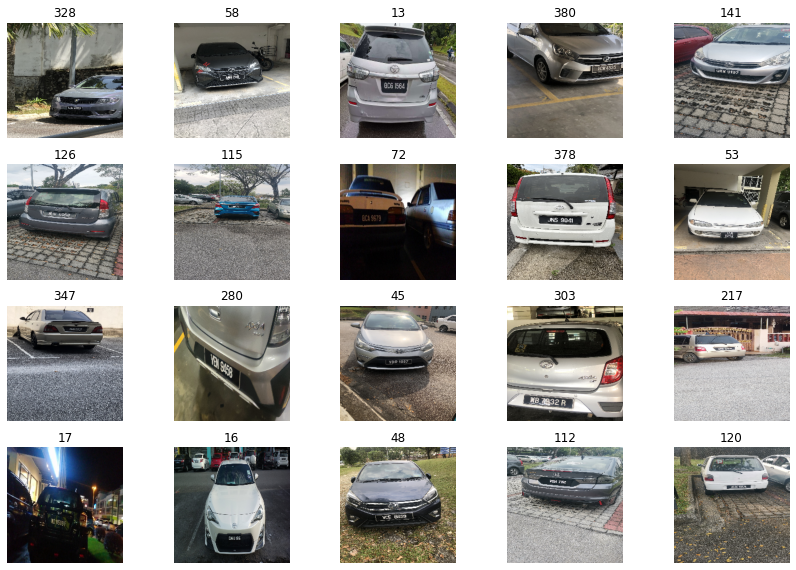

In [10]:
# Randomly visualize data with a seed
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 4
fig_list = []
random.seed(42) # add seed to ensure reproducibility
random_images = random.sample(image_paths, cols*rows)
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(random_images[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(random_images[i], True)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout(True)
plt.show()


**PLATE DETECTION**



- The minimal size of the licence plate that the model will seek for in the picture is determined by the variable **dmin**. 
- It serves as an input for the method get plate() and is used to modify the licence plate's aspect ratio in the picture that the model will search for. 
- The size of the licence plate that the model will search for decreases as the value of dmin decreases, and vice versa. 
- It is by default set to 256. If no licence plate is found, the value of dmin may be set either too high or too low and has to be changed accordingly.

In [11]:
# detect plates from images and return plate location
# if no plates detected, adjust min_dim value
def get_plate(img_path, max_dim=608, min_dim=256):
    img = preprocess_image(img_path)
    aspect_ratio = float(max(img.shape[:2])) / min(img.shape[:2])
    new_side = int(aspect_ratio * min_dim)
    final_dim = min(new_side, max_dim)
    _ , plate_img, plate_type, coords = detect_lp(wpod_net, img, final_dim, lp_threshold=0.5)
    return plate_img, plate_type, coords


**CHOOSE AN IMAGE TO TEST**

Detect 1 plate(s) in 292
Coordinate of plate(s) in image: 
 [array([[115.14010332, 192.56724391, 190.79196231, 113.36482171],
       [136.65317183, 131.05079696, 157.78915638, 163.39153126],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


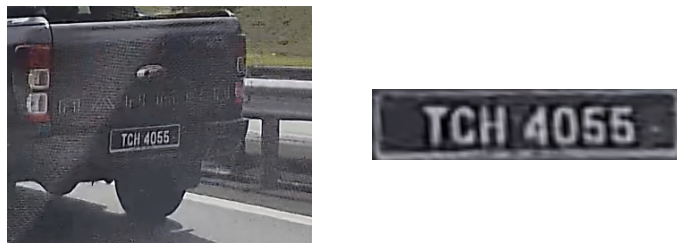

In [37]:
# test_image = random.choice(image_paths)
test_image = image_paths[291]
LpImg, plate_type, cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# output results
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

**CREATE A DRAW BOX FUNCTION**

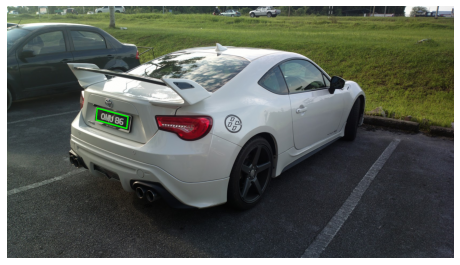

In [35]:
# takes in image path and draw a box
def draw_box(image_path, coordinates, line_width=3):
  points = []
  x_points = coordinates[0][0]
  y_points = coordinates[0][1]
  # stores the top-left, top-right, bottom-left, and bottom-right
  # corners of the license plate
  for i in range(4):
    points.append([int(x_points[i]),int(y_points[i])])
    
  points = np.array(points, np.int32)
  points = points.reshape((-1,1,2))

  processed_image = preprocess_image(image_path)

  cv2.polylines(processed_image,[points],True,(0,255,0),line_width)

  blank_image = np.zeros(processed_image.shape, np.uint8)
  cv2.polylines(blank_image, [points], True, (1), 10)

  return processed_image

# test the function
plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))


**VISUALIZE PLATE IMAGES**

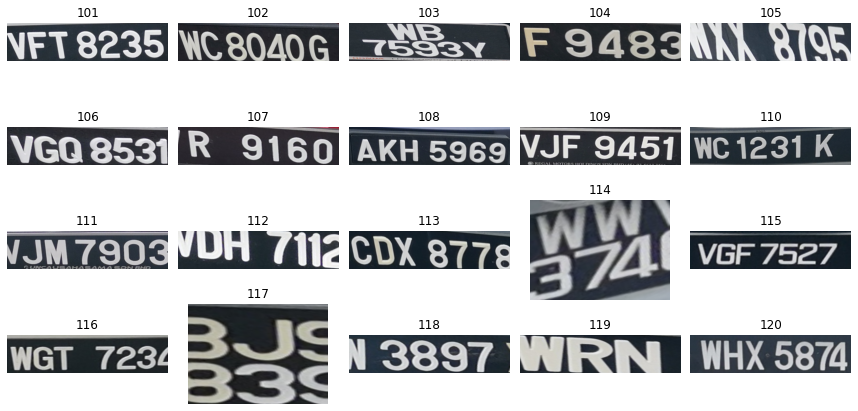

In [14]:
# Visualize some plate images 
fig = plt.figure(figsize=(12,6))
cols = 5
rows = 4
fig_list = []
count = 0
i = 100

while count < rows * cols:
    try:
        LpImg, _, _ = get_plate(image_paths[i])
        fig_list.append(fig.add_subplot(rows, cols, count+1))
        title = splitext(basename(image_paths[i]))[0]
        fig_list[-1].set_title(title)
        plt.axis(False)
        plt.imshow(LpImg[0])
        count += 1
    except AssertionError:
        print(f"No plate detected in {image_paths[i]}")
    i += 1

plt.tight_layout(True)
plt.show()



**PREPROCESSING FOR DETECTED PLATES**

Explaining Preprocessing Code:


1. To improve contrast and improve the legibility of the licence plate text, the detected licence plate picture is scaled and converted to an 8-bit format. Because the wording on the licence plate must be legible for subsequent processing, this is crucial.

2. By removing the colour information from the picture, grayscale conversion makes it simpler to carry out further image processing procedures. For image processing processes that are carried out based on intensity levels, grayscale pictures are more suited.

3. Using Gaussian blur to blur the grayscale image decreases image noise and improves the legibility of the licence plate text. This is crucial since picture noise might make it difficult to see the licence plate's lettering.

4. The blurred image becomes a binary image with black and white pixels when a binary threshold is applied to it. Which pixels are black or white are determined using the threshold value of 180. This step is crucial because it improves the legibility of the lettering on the licence plate.

5. The text on the licence plate is made smaller by applying morphological erosion on the binary picture using a rectangle kernel. The form of the text on the licence plate is maintained by the rectangular kernel. This step is crucial because it increases the visibility and recognizability of the words on the licence plate.

In [15]:
test_image = image_paths[0]
LpImg, plate_type, cor = get_plate(test_image)

# if plate is detected
if (len(LpImg)): 
    # # scales the detected license plate and converts it to 8-bit image
    # plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # # converts the image to grayscale and blurs it
    # gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(gray, (15,15), 1)

    # # applies a binary threshold
    # binary = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

    # # applies a morphological erosion using a rectangular kernel
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # # ERODE 
    # eroded = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel, iterations=1)

    # scales the detected license plate and converts it to 8-bit image
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=255.0)

    # converts the image to grayscale and blurs it
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # applies an inverse binary threshold
    binary = cv2.threshold(blurred, 180, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # applies a morphological dilation using a rectangular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    erode = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel)
  

**ADDITIONAL PROCESS TO STRETCH INTO NORMALIZED ASPECT RATIO**

In [16]:
def normalize_aspect_ratio(image, target_ratio):

    original_height, original_width = image.shape[:2]

    target_width = int(original_width * target_ratio)
    resized_image = cv2.resize(image, (target_width, original_height), interpolation=cv2.INTER_CUBIC)

    return resized_image


def get_aspect_ratio(image):
    height, width = image.shape[:2]
    aspect_ratio = width / height
    return aspect_ratio


**GET ASPECT RATIO FROM A PERFECT DETECTED PLATE**

4.2727272727272725

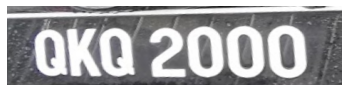

In [17]:
perfectLpImg, _, _ = get_plate(image_paths[6])

plt.axis(False)
plt.imshow(perfectLpImg[0])

ratio = get_aspect_ratio(perfectLpImg[0])
ratio

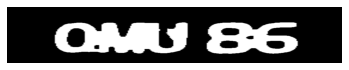

In [18]:
resized = normalize_aspect_ratio(erode, 4.2727272727272725)

plt.axis(False)
plt.imshow(resized,cmap="gray")

**VISUALIZE THE CHANGES**



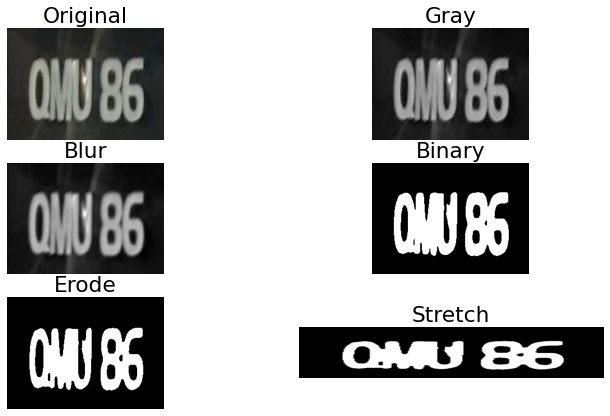

In [19]:
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blurred, binary, erode, resized]
plot_name = ["Original","Gray","Blur","Binary","Erode","Stretch"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

**CREATE FUNCTION THAT GRAB EACH CONTOUR OF DIGITS**

In [20]:
def sort_contours(cnts, reverse=False):
    # Find the bounding box for each contour
    bounding_boxes = [cv2.boundingRect(c) for c in cnts]

    # Sort the contours and their bounding boxes from left to right
    sorted_contours_bounding_boxes = sorted(zip(cnts, bounding_boxes),
                                            key=lambda b: b[1][0],
                                            reverse=reverse)
    if sorted_contours_bounding_boxes:
        # Unzip the sorted contours and their bounding boxes
        sorted_cnts, _ = zip(*sorted_contours_bounding_boxes)
        return sorted_cnts
    else:
        return []

**DRAW RECTANGLE AROUND EACH CONTOUR**

Detected 2 characters


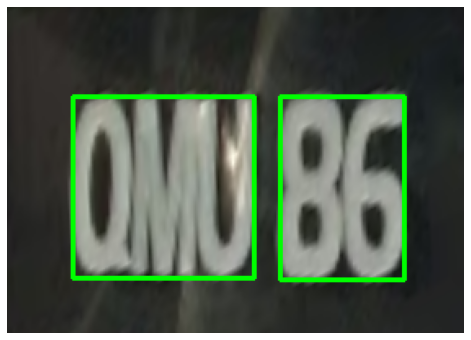

In [21]:
# Find contours 
contours, _ = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

detected_plate = plate_image.copy()
# detected_plate = resized.copy()

cropped_characters = []

# Standard width and height of a character
standard_char_width, standard_char_height = 30, 60

# Loop through the sorted contours
for c in sort_contours(contours):
    # Find the bounding box for each contour
    x, y, w, h = cv2.boundingRect(c)
    
    # Check if the contour meets the aspect ratio criteria
    aspect_ratio = h / w

    # print("check AR")

    if 1 <= aspect_ratio <= 3.5:
        # print("pass AR")

        # Check if the contour meets the height criteria
        height_criteria = h / plate_image.shape[0] >= 0.5
        if height_criteria:
            # print("pass AR")

            # Draw a bounding box around the digit
            cv2.rectangle(detected_plate, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Crop the character from the image and resize it
            current_char = erode[y:y + h, x:x + w]
            current_char = cv2.resize(current_char, dsize=(standard_char_width, standard_char_height))

            # Threshold the character to get a binary image
            _, current_char = cv2.threshold(current_char, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Add the character to the list of cropped characters
            cropped_characters.append(current_char)

# Print the number of detected characters
print("Detected {} characters".format(len(cropped_characters)))

# Plot the detected plate
fig = plt.figure(figsize=(10, 6))
plt.axis(False)
plt.imshow(detected_plate)


**VISUALIZE EACH CONTOUR**

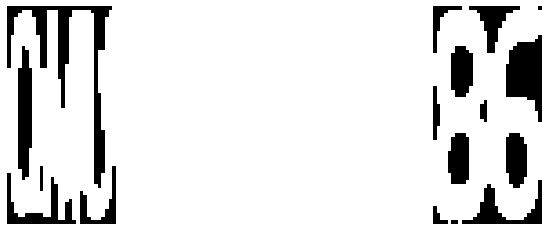

In [22]:
fig, axs = plt.subplots(1, len(cropped_characters), figsize=(14,4))

for i, character in enumerate(cropped_characters):
  axs[i].axis("off")
  axs[i].imshow(character, cmap="gray")

**LOAD PRETRAINED MOBILENETS MODEL**

In [23]:
model_architecture = open(f'{path}wpod-net/MobileNets_character_recognition.json', 'r')
model = model_from_json(model_architecture.read())
model_architecture.close()

model.load_weights(f'{path}wpod-net/License_character_recognition_weight.h5')
print("Model loaded")

labels = np.load(f'{path}wpod-net/license_character_classes.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = labels
print("Labels loaded")



Model loaded
Labels loaded


**CREATE FUNCTION TO PREDICT**

In [24]:
def predict_image_with_model(image, model, labels):
  # Resize image to 80 x 80
  image = cv2.resize(image, (80, 80))

  # Stack image for 3 channel input
  image = np.stack((image,) * 3, axis=-1)

  # Predict with the model
  prediction = labels.inverse_transform(
      [np.argmax(model.predict(image[np.newaxis, :], verbose=0))]
  )

  # Return the prediction
  return prediction


**PREDICT OUTPUT AND VISUALIZE**

W6


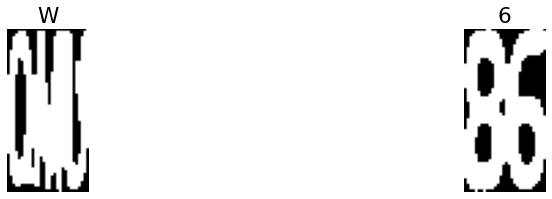

In [25]:
fig = plt.figure(figsize=(15,3))
cols = len(cropped_characters)
grid = gridspec.GridSpec(ncols=cols, nrows=1, figure=fig)

final_string = ''

for i, character in enumerate(cropped_characters):
    # Add subplot to the figure
    fig.add_subplot(grid[i])

    # Predict the character with the model
    title = np.array2string(predict_image_with_model(character, model, label_encoder))

    # Display the character and its prediction
    plt.title('{}'.format(title.strip("'[]"), fontsize=20))
    final_string += title.strip("'[]")
    plt.axis(False)
    plt.imshow(character, cmap='gray')

print(final_string)

**FINAL PIPELINE IN DETECT_PLATE FUNCTION**

In [26]:
def detect_plate(input_img):
    # detection
    # get plate coordinate from input
    try:
        plate_img, plate_type, cor = get_plate(input_img)
    except AssertionError:
        return ""

    # image preprocessing
    # scales the detected license plate and converts it to 8-bit image
    plate_image = cv2.convertScaleAbs(plate_img[0], alpha=255.0)

    # converts the image to grayscale and blurs it
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # applies an inverse binary threshold
    binary = cv2.threshold(blurred, 180, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # applies a morphological dilation using a rectangular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    erode = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel)

    # Find contours of the binary image
    contours, _ = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_plate = plate_image.copy()

    cropped_characters = []

    # Standard width and height of a character
    standard_char_width, standard_char_height = 30, 60

    # Loop through the sorted contours
    for c in sort_contours(contours):
        # Find the bounding box for each contour
        x, y, w, h = cv2.boundingRect(c)

        # Check if the contour meets the aspect ratio criteria
        aspect_ratio = h / w
        if 1 <= aspect_ratio <= 3.5:
            # Check if the contour meets the height criteria
            height_criteria = h / plate_image.shape[0] >= 0.5
            if height_criteria:
              
                # Crop the character from the image and resize it
                current_char = erode[y:y + h, x:x + w]
                current_char = cv2.resize(current_char, dsize=(standard_char_width, standard_char_height))

                # Threshold the character to get a binary image
                _, current_char = cv2.threshold(current_char, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                # Add the character to the list of cropped characters
                cropped_characters.append(current_char)

    # recognition
    final_string = ''

    for i, character in enumerate(cropped_characters):
        # Predict the character with the model
        contour = np.array2string(predict_image_with_model(character, model, label_encoder))

        final_string += contour.strip("'[]")

    return final_string


**ALL PREDICTED OUTPUT**

In [27]:
# pipeline_1 = []
# for i in image_paths:
#   img = cv2.imread(i)
#   plate = detect_plate(img)
#   fName = i.split("/")[-1]
#   print(f"{fName}: {plate}")
#   pipeline_1.append(plate)
  


**EVALUATION FUNCTION**

In [28]:
import matplotlib.cm as cm
import importlib
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
import json

In [29]:

# Default parameters (the only code you can change)
def jaccard(output, gt):
    _output = set(output)
    _gt = set(gt)
    intersection = len(_output.intersection(_gt))
    union = len(_output.union(_gt))
    return round((intersection / union), 4)


input_dir = f"{path}dataset"
ground_truth_filename = f"{path}ground_truth.json"
numImages = 20
onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
onlyfiles.sort(key= lambda f: int(f.split('.')[0]))
files = onlyfiles[0:numImages]


gt_file = open(ground_truth_filename)
gt_dict = json.load(gt_file)

acc = np.zeros(numImages)
jaccard_similarity = np.zeros(numImages)
output_plate = [None] * numImages

for i, name in enumerate(files):
    input_img = cv2.imread(input_dir + "/" + name)
    output_plate[i] = detect_plate(input_img)
    img_key = i + 1
    gt_plate = gt_dict[str(img_key)]
    acc[i] = 1 if output_plate[i] == gt_plate else 0
    jaccard_similarity[i] = jaccard(output_plate[i], gt_plate)

# Print performance scores
print("####  IMAGE RESULTS  ####")
t = PrettyTable(["Image", "Accuracy", "Jaccard Similarity", "Original", "Predicted"])
avg_acc = np.mean(acc)
avg_jaccard_similarity = np.mean(jaccard_similarity)


for i in range(numImages):
    t.add_row([i + 1, "Yes" if acc[i] == 1 else "No", jaccard_similarity[i], gt_dict[str(i + 1)], output_plate[i]])

print(t)
print(f"Average Accuracy: {avg_acc}")
print(f"Average Jaccard Similarity: {avg_jaccard_similarity}")

# END OF EVALUATION CODE####################################################

####  IMAGE RESULTS  ####
+-------+----------+--------------------+----------+-----------+
| Image | Accuracy | Jaccard Similarity | Original | Predicted |
+-------+----------+--------------------+----------+-----------+
|   1   |    No    |       0.1667       |  QMU86   |     W6    |
|   2   |    No    |       0.7143       | QTD6957  |   TD695   |
|   3   |    No    |       0.375        | QMF3325  |   GNF35   |
|   4   |    No    |       0.1667       |  QSF75   |    SSX    |
|   5   |    No    |        0.6         | BJY6688  |    BJY    |
|   6   |    No    |       0.3333       | KBB8888  |     8     |
|   7   |    No    |        1.0         | QKQ2000  |  QK02000  |
|   8   |    No    |        0.0         | QAU2412  |     WP    |
|   9   |    No    |        0.4         |  QMU86   |     U6    |
|   10  |    No    |       0.7143       | DBK8548  |  DBK85A8  |
|   11  |    No    |       0.7143       | QCE5195  |  0CE5195  |
|   12  |    No    |        0.0         | QAT3111  |           |

**TESTING DIFFERENT MODEL**

In [30]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 27 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,703 kB/s)
debconf: unable to initialize fronten

In [31]:
!pip install pytesseract==0.3.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [32]:
import pytesseract
from PIL import Image

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [33]:

def detect_plate_pytesseract(input_img):
    # detection
    # get plate coordinate from input
    try:
        plate_img, plate_type, cor = get_plate(input_img)
    except AssertionError:
        return ""

    # image preprocessing
    # scales the detected license plate and converts it to 8-bit image
    plate_image = cv2.convertScaleAbs(plate_img[0], alpha=255.0)

    # converts the image to grayscale and blurs it
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # applies an inverse binary threshold
    binary = cv2.threshold(blurred, 180, 255,
                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # applies a morphological dilation using a rectangular kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    erode = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel)
    erode = erode * 255
    img_final = Image.fromarray(erode)

    # plt.imshow(erode)
    # print(img_final)

    # recognition

    predicted_result = pytesseract.image_to_string(img_final, lang ='eng', config ='--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHJKLMNPQRSTUVWXY0123456789')
    filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")

    if filter_predicted_result == "":
        predicted_result = pytesseract.image_to_string(input_img, lang ='eng', config ='--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHJKLMNPQRSTUVWXY0123456789')
        filter_predicted_result = "".join(predicted_result.split()).replace(":", "").replace("-", "")

    return filter_predicted_result

**EVALUATION**

In [34]:

# Default parameters (the only code you can change)
def jaccard(output, gt):
    _output = set(output)
    _gt = set(gt)
    intersection = len(_output.intersection(_gt))
    union = len(_output.union(_gt))
    return round((intersection / union), 4)


input_dir = f"{path}dataset"
ground_truth_filename = f"{path}ground_truth.json"
numImages = 20
onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
onlyfiles.sort(key= lambda f: int(f.split('.')[0]))
files = onlyfiles[0:numImages]
# files = onlyfiles[1:2]

gt_file = open(ground_truth_filename)
gt_dict = json.load(gt_file)

acc = np.zeros(numImages)
jaccard_similarity = np.zeros(numImages)
output_plate = [None] * numImages

for i, name in enumerate(files):
    input_img = cv2.imread(input_dir + "/" + name)
    output_plate[i] = detect_plate_pytesseract(input_img)
    img_key = i + 1
    gt_plate = gt_dict[str(img_key)]
    acc[i] = 1 if output_plate[i] == gt_plate else 0
    jaccard_similarity[i] = jaccard(output_plate[i], gt_plate)

# Print performance scores
print("####  IMAGE RESULTS  ####")
t = PrettyTable(["Image", "Accuracy", "Jaccard Similarity", "Original", "Predicted"])
avg_acc = np.mean(acc)
avg_jaccard_similarity = np.mean(jaccard_similarity)


for i in range(numImages):
    t.add_row([i + 1, "Yes" if acc[i] == 1 else "No", jaccard_similarity[i], gt_dict[str(i + 1)], output_plate[i]])

print(t)
print(f"Average Accuracy: {avg_acc}")
print(f"Average Jaccard Similarity: {avg_jaccard_similarity}")

# END OF EVALUATION CODE####################################################

KeyError: ignored

**EVALUATE DETECTION MODEL WITH ROI**

**DETECTION EVALUATION CODE**

OUTPUT: NPARRAY OF 0 AND 1

In [ ]:
def detect_ROI(input_img):

  blank_image = np.zeros(input_img.shape[:-1], np.uint8)

  # detection
  # get plate coordinate from input
  try:
      plate_img, plate_type, coordinates = get_plate(input_img)
  except AssertionError:
      return blank_image

  points = []
  x_points = coordinates[0][0]
  y_points = coordinates[0][1]
  # stores the top-left, top-right, bottom-left, and bottom-right
  # corners of the license plate
  for i in range(4):
    points.append([int(x_points[i]),int(y_points[i])])
    
  points = np.array(points, np.int32)
  points = points.reshape((-1,1,2))

  cv2.fillPoly(blank_image, pts=[points], color=(1))
  
  return blank_image

In [ ]:

# for i in range(400):
#   img = cv2.imread(image_paths[i])
#   plate = detect_ROI(img)
#   print(np.unique(plate))
#   # plt.imshow(plate)



**EVALUATION CODE**

In [ ]:
from lxml import etree

eps = 0.00000001

# Default parameters (the only code you can change)
def getROI(f):
  tree = etree.parse(f)

  d = tree.xpath("size")[0]
  w = int(d.xpath("width")[0].text)
  h = int(d.xpath("height")[0].text)

  d = tree.xpath("object/bndbox")[0]
  xMin = int(d.xpath("xmin")[0].text)
  xMax = int(d.xpath("xmax")[0].text)
  yMin = int(d.xpath("ymin")[0].text)
  yMax = int(d.xpath("ymax")[0].text)

  img = np.zeros((h, w), dtype=np.uint8)
  img = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (1), -1)

  return img

input_dir = f"{path}dataset"
annotations_dir = f"{path}annotations"


numImages = 20
onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
onlyfiles.sort(key= lambda f : int(f.split(".")[0]))
files = onlyfiles[0:numImages]

onlyannotates = [f for f in listdir(annotations_dir) if isfile(join(annotations_dir, f))]
onlyannotates.sort(key= lambda f : int(f.split(".")[0]))
annotates = onlyannotates[0:numImages]

error = np.zeros(numImages)
precision = np.zeros(numImages)
recall = np.zeros(numImages)
iou = np.zeros(numImages)

for i, (name, annotate) in enumerate(zip(files, annotates)):
  input_img = cv2.imread(input_dir + "/" + name)

  gtPart = getROI(annotations_dir + "/" + annotate)
  outputPart = detect_ROI(input_img)

  gtPart = gtPart.astype("float32")
  outputPart = outputPart.astype("float32")

  precision[i] = sum(sum(gtPart*outputPart))/(sum(sum(outputPart))+eps)
  recall[i] = sum(sum(gtPart*outputPart))/sum(sum(gtPart))
  error[i] = 1 - ((2*precision[i]*recall[i])/(precision[i]+recall[i]+eps))
  iou[i] = sum(sum(gtPart*outputPart))/sum(sum(np.clip(gtPart+outputPart,0,1)))

# Print performance scores
print("####  IMAGE ROI RESULTS  ####")
t = PrettyTable(['Image', 'Error','Precision','Recall','IoU'])
avg_error = np.mean(error)
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_iou = np.mean(iou)

for i in range(numImages):
    t.add_row([i+1, 
               str(round(error[i], 4)), 
               str(round(precision[i], 4)), 
               str(round(recall[i], 4)), 
               str(round(iou[i], 4))
    ])

print(t)
print(f"Average Error: {avg_error}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average IoU: {avg_iou}")

# END OF EVALUATION CODE####################################################